#CS412 SPRING 2022 - 2023 TERM PROJECT
##Machine Learning Pipeline for Credit Risk Analysis with the German Credit Data
Group GC-6:
- Zeynep Kurtuluş 29045
- Sezin Tekin 28884
- Ege Öngül 29037
- Ozan Çelebi 29486


In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
#import necessary libraries
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import plot_confusion_matrix


# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
from sklearn.preprocessing import LabelEncoder
pd.options.display.float_format = '{:,.3f}'.format




In [ ]:
# Load data
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/german_credit_data.csv') # enter the file path on your drive for the csv file

# Replace NA values with 0
data.fillna(0, inplace=True)

data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,0,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,0,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
data.columns
data.shape

(1000, 11)

# Exploratory Data Analysis (EDA)

In [ ]:
print("Purpose : ",data.Purpose.unique())
print("Sex : ",data.Sex.unique())
print("Housing : ",data.Housing.unique())
print("Saving accounts : ",data['Saving accounts'].unique())
print("Checking account : ",data['Checking account'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [0 'little' 'quite rich' 'rich' 'moderate']
Checking account :  ['little' 'moderate' 0 'rich']


In [ ]:
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]  # Last column as the target variable

# Display dataset details
num_samples = len(data)
num_features = len(X.columns)
num_good_credit = len(data[data['Risk'] == 'good'])
num_bad_credit = len(data[data['Risk'] == 'bad'])

print("Dataset Details:")
print("Number of samples:", num_samples)
print("Number of features:", num_features)
print("Number of 'good credit' samples:", num_good_credit)
print("Number of 'bad credit' samples:", num_bad_credit)

Dataset Details:
Number of samples: 1000
Number of features: 10
Number of 'good credit' samples: 700
Number of 'bad credit' samples: 300


In [ ]:
data['Saving accounts'] = data['Saving accounts'].map({"little":0,"moderate":1,"quite rich":2 ,"rich":3 });
data['Saving accounts'] = data['Saving accounts'].fillna(data['Saving accounts'].dropna().mean())

data['Checking account'] = data['Checking account'].map({"little":0,"moderate":1,"rich":2 });
data['Checking account'] = data['Checking account'].fillna(data['Checking account'].dropna().mean())

data['Sex'] = data['Sex'].map({"male":0,"female":1}).astype(float);

data['Housing'] = data['Housing'].map({"own":0,"free":1,"rent":2}).astype(float);

data['Purpose'] = data['Purpose'].map({'radio/TV':0, 'education':1, 'furniture/equipment':2, 'car':3, 'business':4,
       'domestic appliances':5, 'repairs':6, 'vacation/others':7}).astype(float);

data.head(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,0.000,2,0.000,0.457,0.000,1169,6,0.000,good
1,1,22,1.000,2,0.000,0.000,1.000,5951,48,0.000,bad
2,2,49,0.000,1,0.000,0.000,0.652,2096,12,1.000,good
3,3,45,0.000,2,1.000,0.000,0.000,7882,42,2.000,good
4,4,53,0.000,2,1.000,0.000,0.000,4870,24,3.000,bad
5,5,35,0.000,1,1.000,0.457,0.652,9055,36,1.000,good
6,6,53,0.000,2,0.000,2.000,0.652,2835,24,2.000,good
7,7,35,0.000,3,2.000,0.000,1.000,6948,36,3.000,good
8,8,61,0.000,1,0.000,3.000,0.652,3059,12,0.000,good
9,9,28,0.000,3,0.000,0.000,1.000,5234,30,3.000,bad


In [ ]:
# Check for duplicate values
data.duplicated().sum()

0

In [ ]:
# let's view the statistical summary of the numerical columns in the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,"1,000.000",499.500,288.819,0.000,249.750,499.500,749.250,999.000
Age,"1,000.000",35.546,11.375,19.000,27.000,33.000,42.000,75.000
Sex,"1,000.000",0.310,0.463,0.000,0.000,0.000,1.000,1.000
Job,"1,000.000",1.904,0.654,0.000,2.000,2.000,2.000,3.000
Housing,"1,000.000",0.466,0.779,0.000,0.000,0.000,1.000,2.000
Saving accounts,"1,000.000",0.457,0.786,0.000,0.000,0.000,0.457,3.000
Checking account,"1,000.000",0.652,0.514,0.000,0.000,0.652,1.000,2.000
Credit amount,"1,000.000","3,271.258","2,822.737",250.000,"1,365.500","2,319.500","3,972.250","18,424.000"
Duration,"1,000.000",20.903,12.059,4.000,12.000,18.000,24.000,72.000
Purpose,"1,000.000",2.096,1.630,0.000,0.000,2.000,3.000,7.000


In [ ]:
# Making a list of all categorical variables
cat_col = [
    "Sex",
    "Job",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
    "Risk",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

0.000    690
1.000    310
Name: Sex, dtype: int64
----------------------------------------
2    630
1    200
3    148
0     22
Name: Job, dtype: int64
----------------------------------------
0.000    713
2.000    179
1.000    108
Name: Housing, dtype: int64
----------------------------------------
0.000    603
0.457    183
1.000    103
2.000     63
3.000     48
Name: Saving accounts, dtype: int64
----------------------------------------
0.652    394
0.000    274
1.000    269
2.000     63
Name: Checking account, dtype: int64
----------------------------------------
3.000    337
0.000    280
2.000    181
4.000     97
1.000     59
6.000     22
5.000     12
7.000     12
Name: Purpose, dtype: int64
----------------------------------------
good    700
bad     300
Name: Risk, dtype: int64
----------------------------------------


In [ ]:
# UNIVARIATE ANALYSIS OF THE DATA
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram






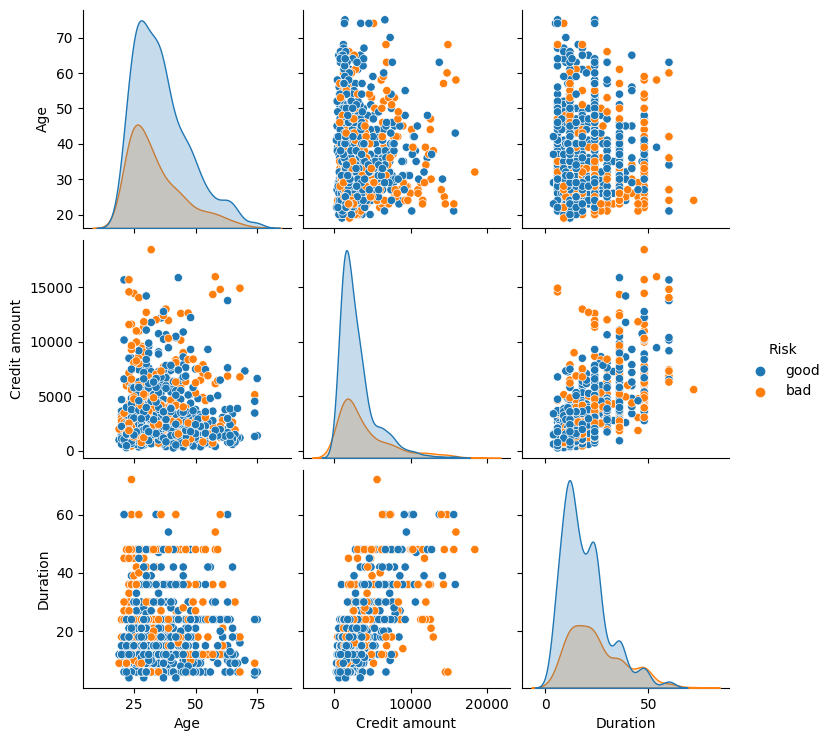

In [ ]:
#Pair plot of numerical variables
num_cat_risk = ['Age', 'Credit amount', 'Duration', 'Risk']
sns.pairplot(data[num_cat_risk], hue="Risk")
plt.show()

* The distribution plots for Age, Credit amount, and Duration have a positive skew


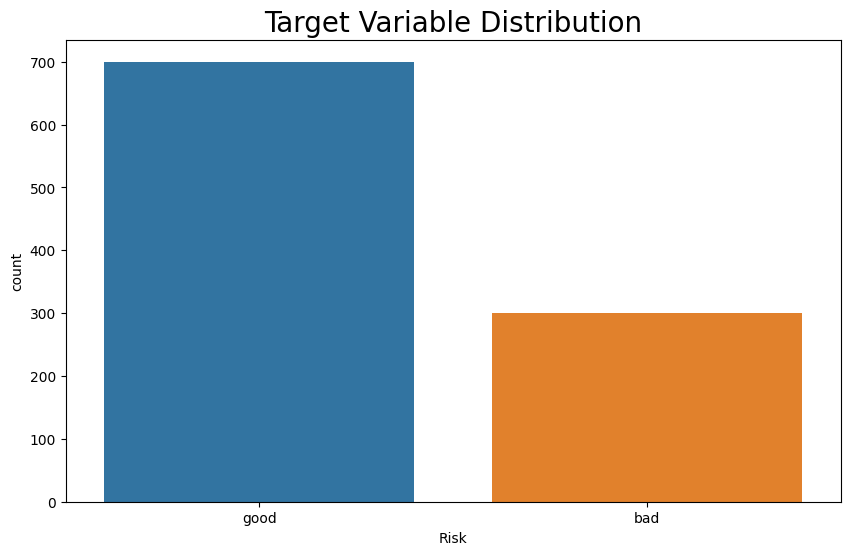

In [ ]:
#Target Variable Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data, x="Risk")
plt.title("Target Variable Distribution", fontsize=20)
plt.show()

* There are 700 instances where an applicant was classified as good
* There are 300 instances where an applicant was classified as bad

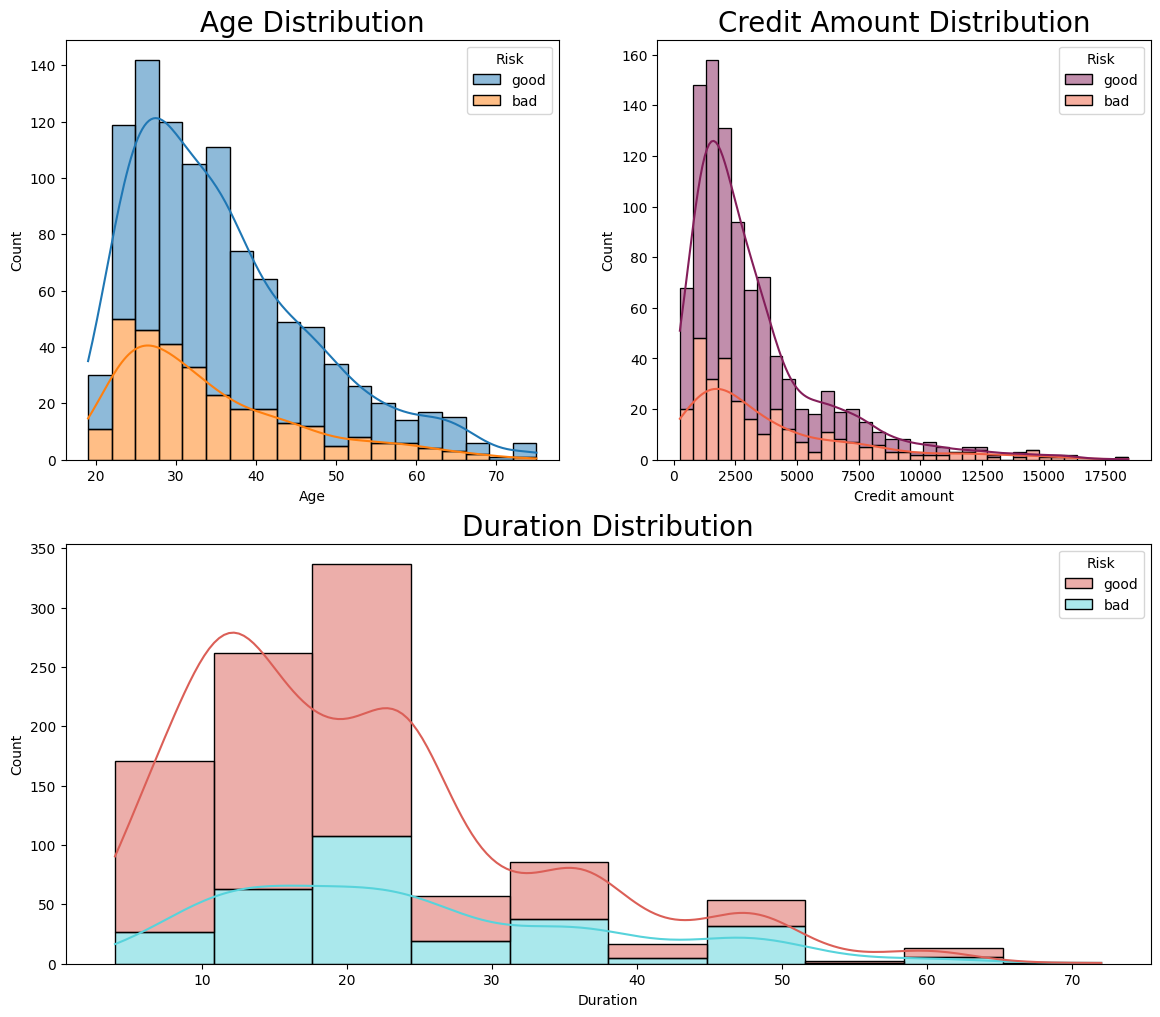

In [ ]:
#Age distribution
plt.figure(figsize=(14, 12))

plt.subplot(221)
ax1 = sns.histplot(data, x='Age', hue='Risk', multiple='stack', palette='tab10', kde=True)
ax1.set_title("Age Distribution", fontsize=20)

plt.subplot(222)
ax2 = sns.histplot(data, x='Credit amount', hue='Risk', multiple='stack', palette='rocket', kde=True)
ax2.set_title("Credit Amount Distribution", fontsize=20)

plt.subplot(212)
ax3 = sns.histplot(data, x='Duration', hue='Risk', multiple='stack', palette='hls', kde=True, bins=10)
ax3.set_title("Duration Distribution", fontsize=20)

plt.show()

* All graphs have a positive skew indicating that the mean is greater than the median
* Applicants between the ages of 20 to 30 are more likely to apply for a loan
* Applicants are less likely to apply for a high credit loan
* More loans have been paid off around 20 months after being issued
* The bank is more likely to receive applicants between the ages of 20 and 30 and request loans between 250 and 2500 DM

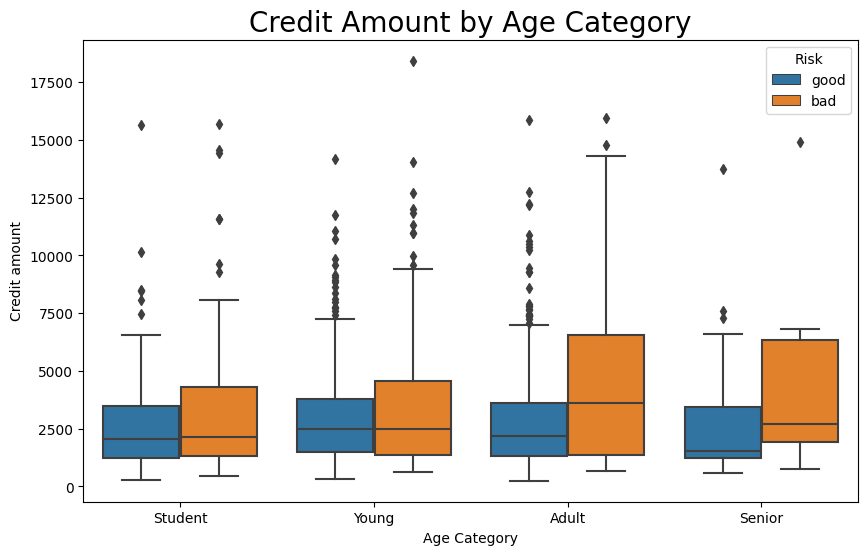

In [ ]:
#Credit Ammount buy Age Category
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
data["Age Category"] = pd.cut(data.Age, interval, labels=cats)

plt.figure(figsize=(10, 6))
plt.title("Credit Amount by Age Category", fontsize=20)
sns.boxplot(data, x='Age Category', y='Credit amount', hue='Risk')
plt.show()

* More than 50% of the applicants with credit amounts below 5,000 DM are classified as good
* Adults with loan credit greater than 5,000 DM are more likely to classify as bad
* Students and Young applicants are most likely to apply for loans with a credit amount of less than 5,000 DM

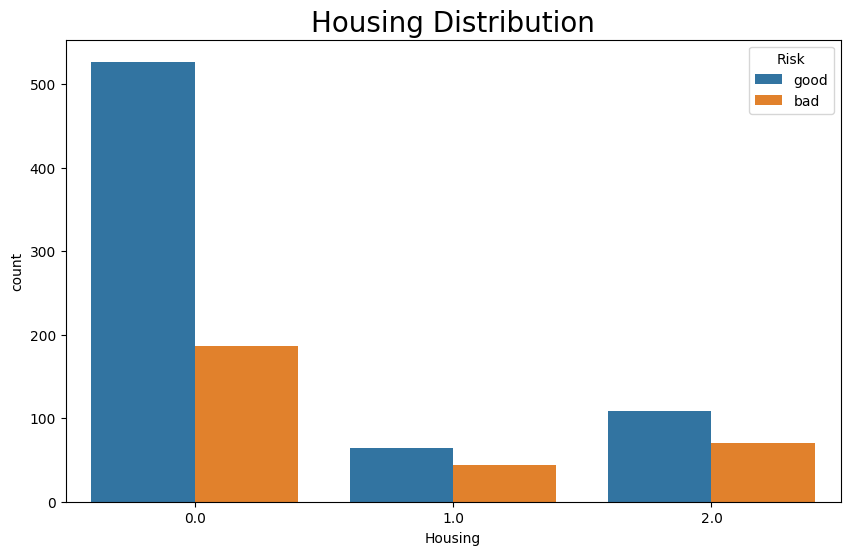

In [ ]:
#Housing Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data, x='Housing', hue='Risk')
plt.title("Housing Distribution", fontsize=20)
plt.show()

* Most applicants own a house
* Over half of the applicants who own a house classified as good

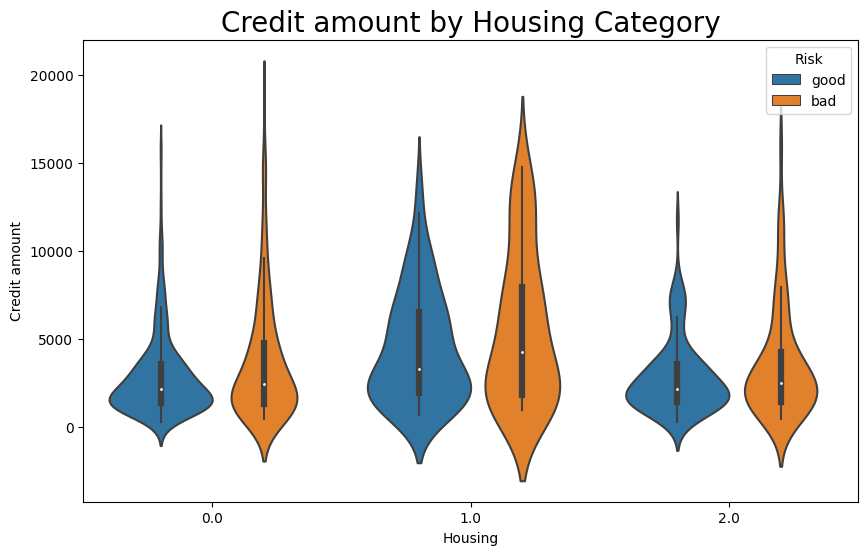

In [ ]:
#Credit Amount by Housing Distribution
plt.figure(figsize=(10, 6))
sns.violinplot(data, x='Housing', y='Credit amount', hue='Risk')
plt.title("Credit amount by Housing Category", fontsize=20)
plt.show()

The density curves from the violin plot suggest that there is a higher frequency of applicants with credit amounts below 5,000 DM

Text(0.5, 1.0, 'Job Category by Gender')

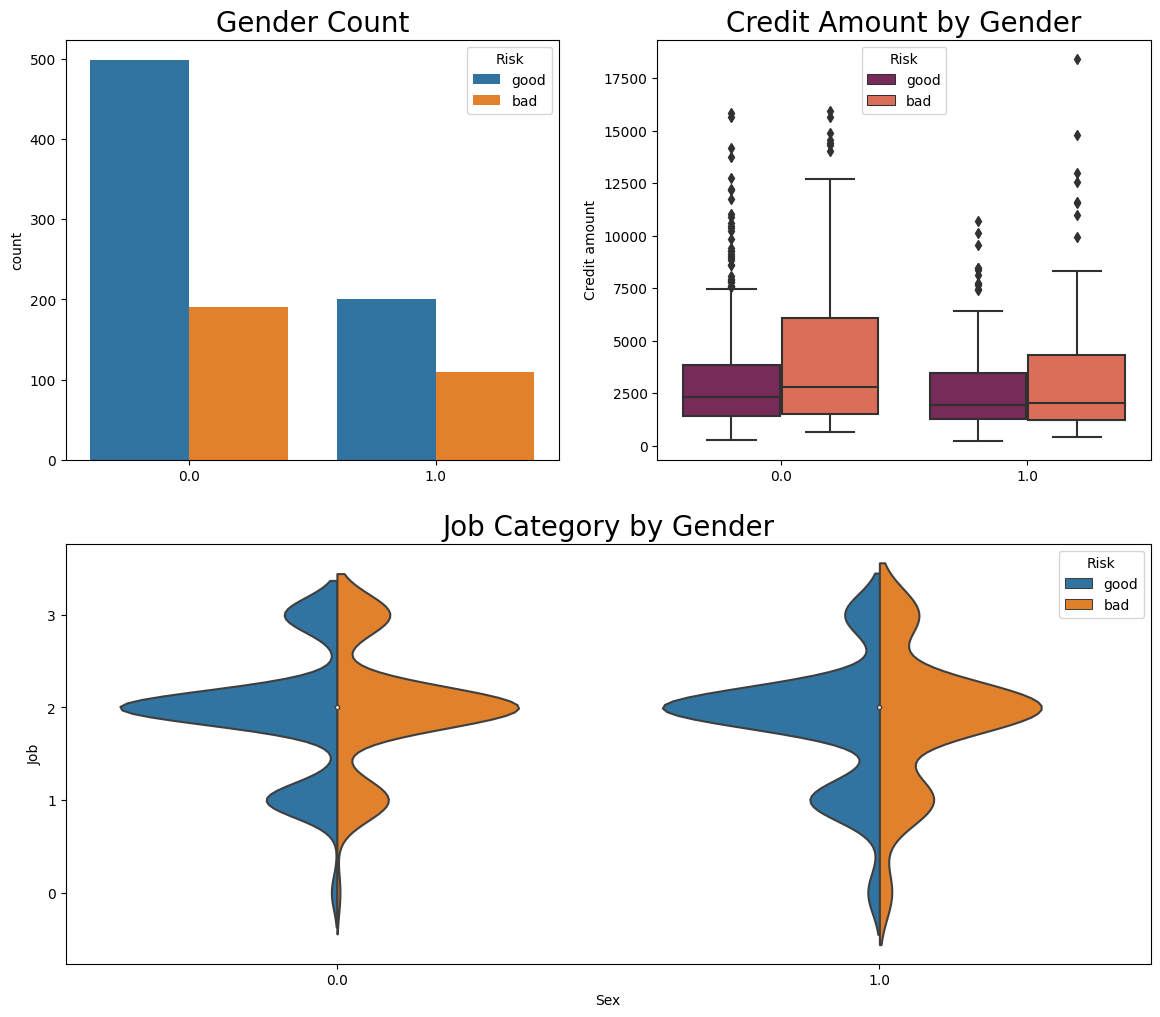

In [ ]:
#Distribution by Gender
plt.figure(figsize=(14, 12))
plt.subplot(221)
ax1 = sns.countplot(data, x='Sex', hue='Risk', palette='tab10')
ax1.set_title("Gender Count", fontsize=20)
ax1.set_xlabel("")

plt.subplot(222)
ax2 = sns.boxplot(data, x='Sex', y='Credit amount', palette='rocket', hue='Risk')
ax2.set_title("Credit Amount by Gender", fontsize=20)
ax2.set_xlabel("")

plt.subplot(212)
ax3 = sns.violinplot(data, x='Sex', y='Job', hue='Risk', split=True)
ax3.set_title("Job Category by Gender", fontsize=20)

* There are 2x more male applicants than females in the data
* The majority of applicants are in the skilled job category
* About 2/5 of male applicants and 1/3 of female applicants are classified as bad
* The density distribution from the violin plots follows the same trend suggesting that the majority of the male and female applicants are categorized as skilled workers

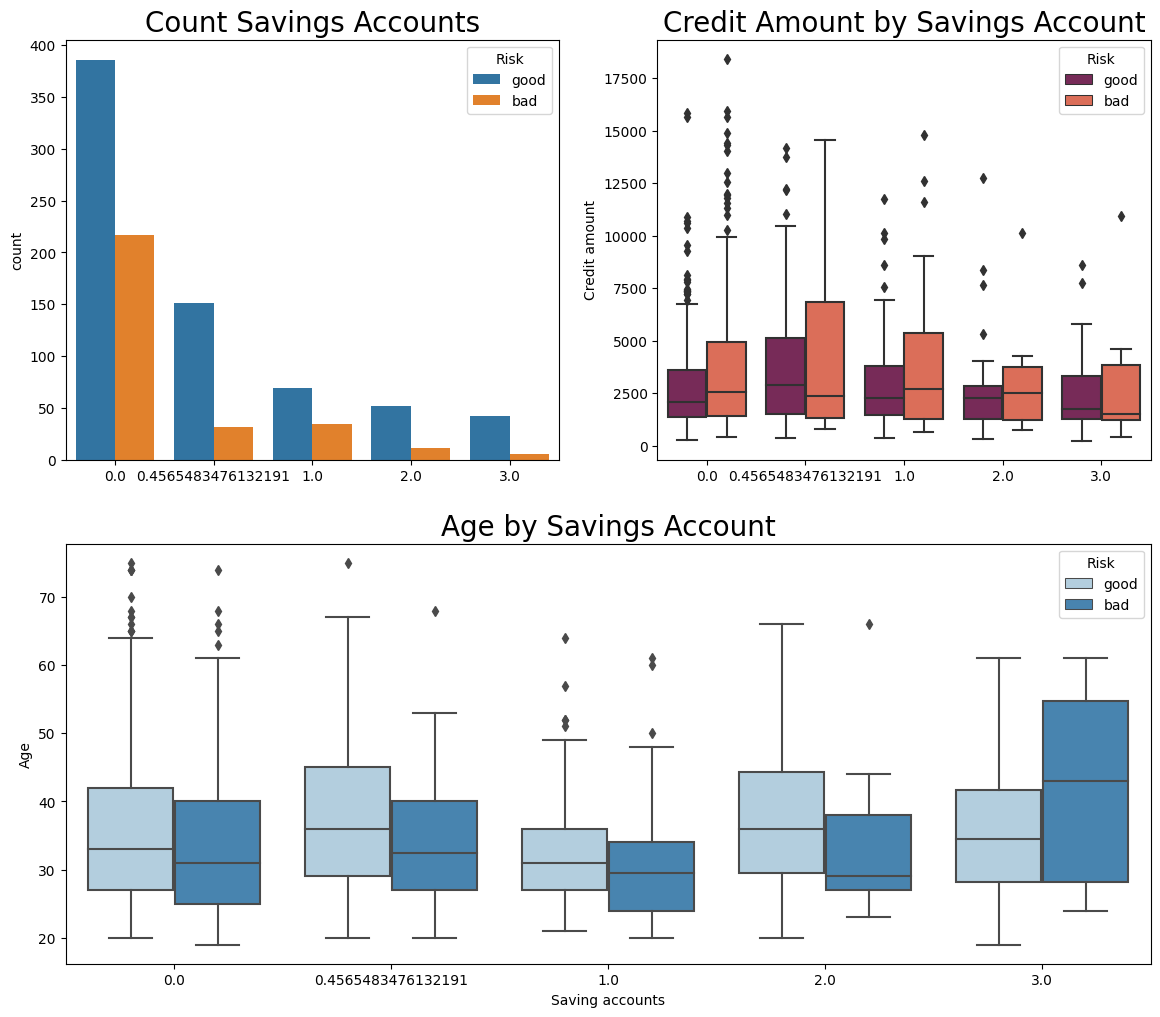

In [ ]:
#Saving Accounts Distribution
plt.figure(figsize=(14, 12))
plt.subplot(221)
ax1 = sns.countplot(data, x='Saving accounts', hue='Risk', palette='tab10')
ax1.set_title("Count Savings Accounts", fontsize=20)
ax1.set_xlabel("")

plt.subplot(222)
ax2 = sns.boxplot(data, x='Saving accounts', y='Credit amount', hue='Risk', palette='rocket')
ax2.set_title("Credit Amount by Savings Account", fontsize=20)
ax2.set_xlabel("")

plt.subplot(212)
ax3 = sns.boxplot(data, x='Saving accounts', y='Age', hue='Risk', palette='Blues')
ax3.set_title("Age by Savings Account", fontsize=20)

plt.show()

* Applicants with little or no saving accounts are more likely to apply for loans
* The majority of the applicants are in the little category
50% of the applicants in the little category are between the age range of 25 and 45
* Applicants with moderate, quite rich, and rich savings accounts are more likely to be classified as good
* Applicants with little and no savings accounts with a credit amount loan that exceeds 5,000 DM are more likely to classify as bad

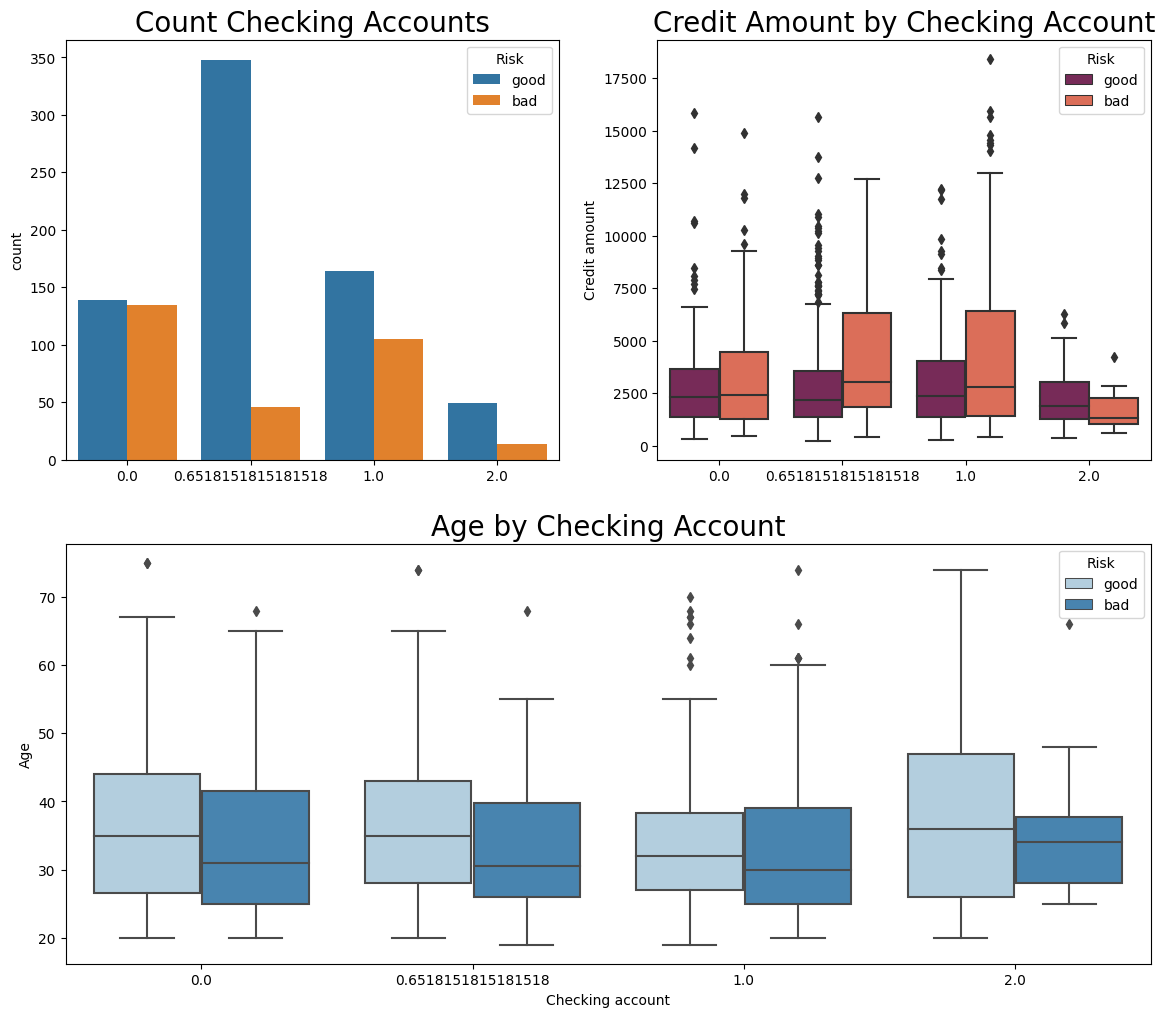

In [ ]:
#Checking Accounts Distribution
plt.figure(figsize=(14, 12))
plt.subplot(221)
ax1 = sns.countplot(data, x='Checking account', hue='Risk', palette='tab10')
ax1.set_title("Count Checking Accounts", fontsize=20)
ax1.set_xlabel("")

plt.subplot(222)
ax2 = sns.boxplot(data, x='Checking account', y='Credit amount', hue='Risk', palette='rocket')
ax2.set_title("Credit Amount by Checking Account", fontsize=20)
ax2.set_xlabel("")

plt.subplot(212)
ax3 = sns.boxplot(data, x='Checking account', y='Age', hue='Risk', palette='Blues')
ax3.set_title("Age by Checking Account", fontsize=20)

plt.show()

* More than 300 hundred applicants had no checking accounts
* More than 3x the applicants that didn’t have checking accounts were classified as good
* 50% of the applicants that had moderate checking accounts were between the age range of 25 to 40
* There is a larger dispersion of applicants with rich checking accounts that are classified as good and are between the ages of 25 and 45
* Applicants with a high credit amount and little in their checking accounts are more likely to classify as bad


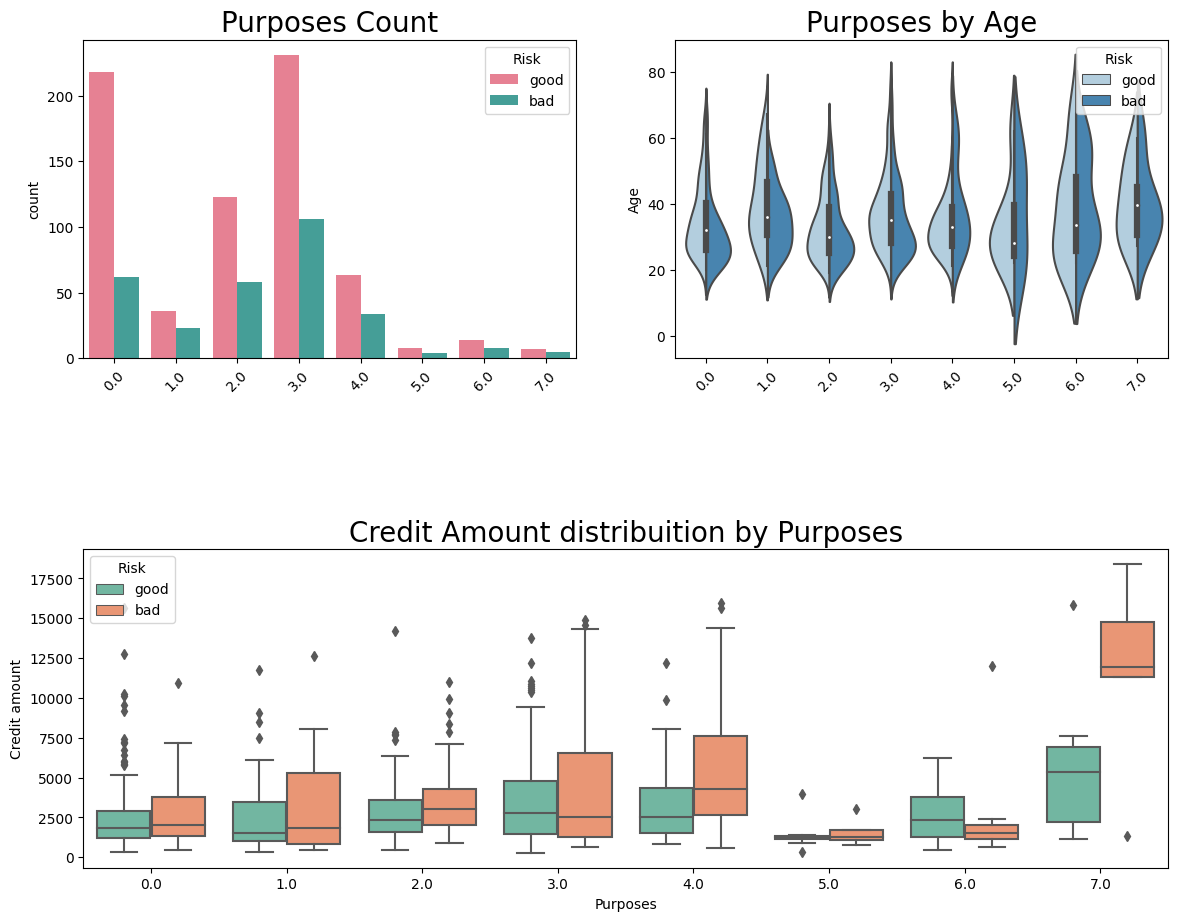

In [ ]:
#Distribution by Purpose
plt.figure(figsize = (14,12))

plt.subplot(221)
ax1 = sns.countplot(data, x="Purpose", palette="husl", hue = "Risk")
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_xlabel("")
ax1.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
ax2 = sns.violinplot(data, x="Purpose", y="Age", palette="Blues", hue = "Risk",split=True)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_xlabel("")
ax2.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
ax3 = sns.boxplot(data, x="Purpose", y="Credit amount", palette="Set2", hue = "Risk")
ax3.set_xlabel("Purposes")
ax3.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

* A large portion of applicants requested loans for buying cars, radios/tv’s
* More than half of the applicants applied for loans less than 5,000 DM
* Applicants with high credit loans are more likely to classify as bad

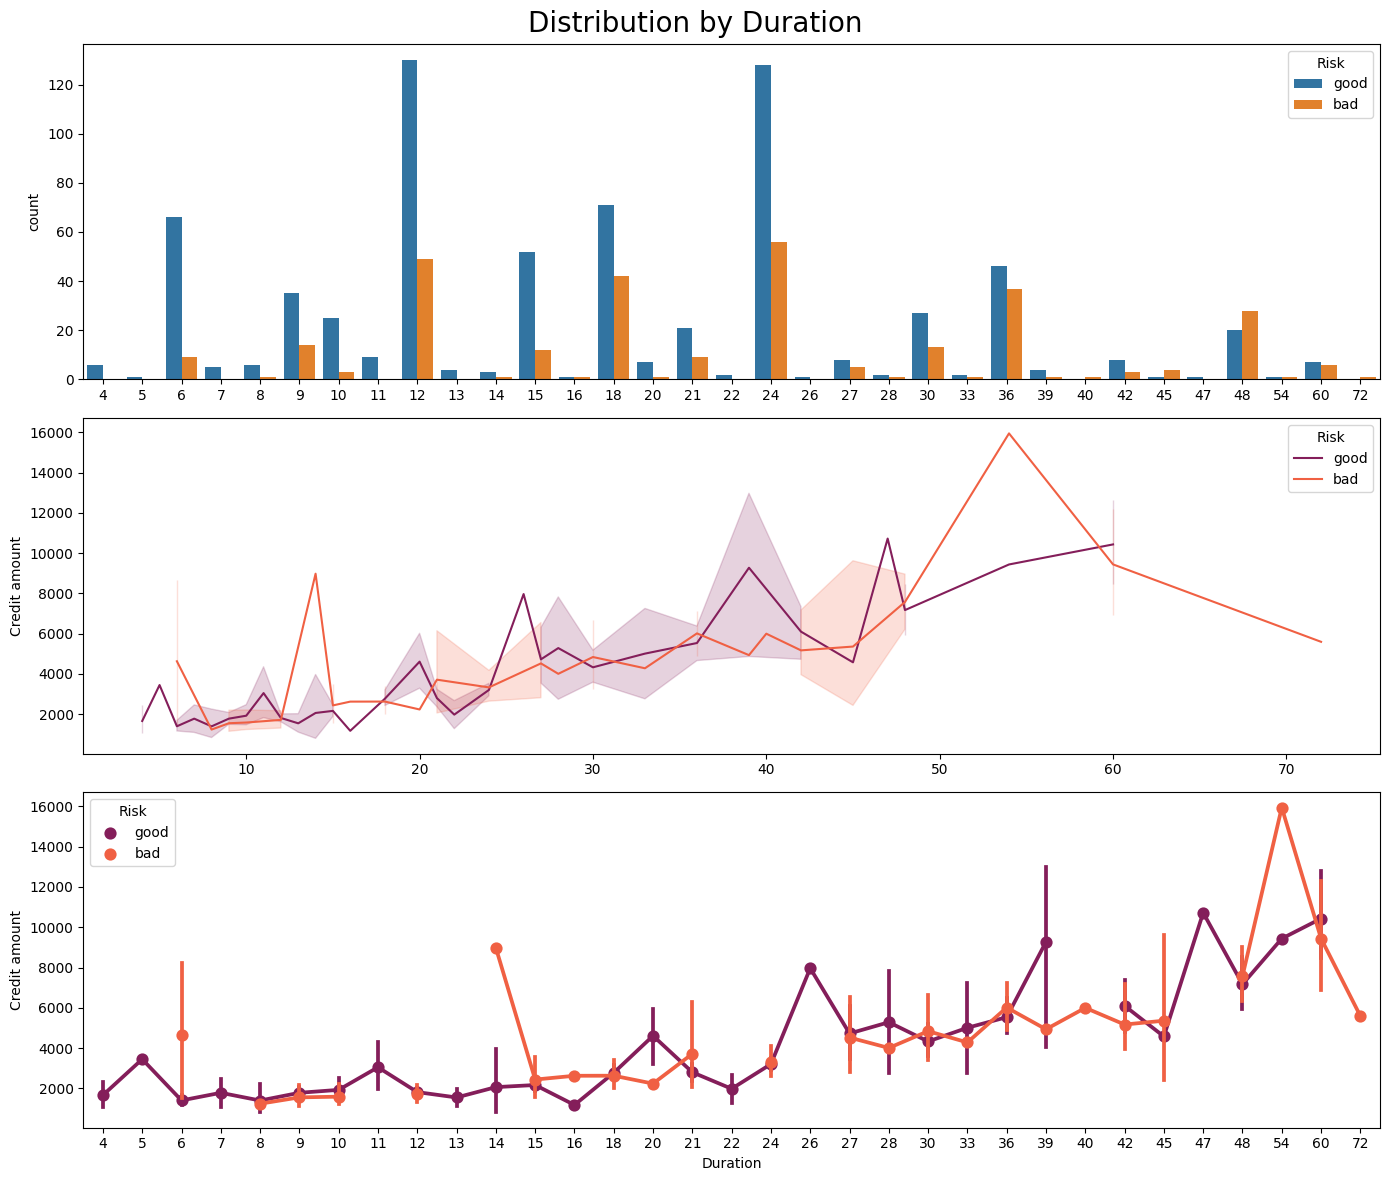

In [ ]:
#Distribution by Duration
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle("Distribution by Duration", fontsize=20)
sns.countplot(data, x='Duration', hue='Risk', palette='tab10', ax=ax1)
ax1.set_xlabel("")

sns.lineplot(data, x='Duration', y='Credit amount', hue='Risk', palette='rocket', ax=ax2)
ax2.set_xlabel("")

sns.pointplot(data, x='Duration', y='Credit amount', hue='Risk', palette='rocket', ax=ax3)
fig.tight_layout()
plt.show()


* Most of the loans issued had a duration of 12 and 24 months
* Most applicants that repaid their loans within 24 months are classified as good
* Most applicants with a loan duration that exceeds 24 months are classified as bad

In [ ]:
# Data Preparation for Modeling
df = pd.DataFrame(data)
X = df[['Age', 'Sex', 'Job','Housing','Saving accounts','Checking account', 'Credit amount','Duration', 'Purpose']]
y = df["Risk"]


In [ ]:
# Splitting data into training, validation and test sets:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print("The Shape of the Train Set is: ", X_train.shape)
print("The Shape of the Validation Set is: ", X_val.shape)
print("The Shape of the Test Set is: ", X_test.shape)

The Shape of the Train Set is:  (600, 9)
The Shape of the Validation Set is:  (200, 9)
The Shape of the Test Set is:  (200, 9)


In [ ]:
import pandas as pd

# Define the dataframes for train, test, and validation sets
train_df = pd.DataFrame(X_train.head(5))
test_df = pd.DataFrame(X_test.head(5))
val_df = pd.DataFrame(X_val.head(5))

# Print the formatted table for the Train Set
print("Example entry of the Train Set:")
print(train_df.to_string(index=False))
print()

# Print the formatted table for the Test Set
print("Example entry of the Test Set:")
print(test_df.to_string(index=False))
print()

# Print the formatted table for the Validation Set
print("Example entry of the Validation Set:")
print(val_df.to_string(index=False))


Example entry of the Train Set:
 Age   Sex  Job  Housing  Saving accounts  Checking account  Credit amount  Duration  Purpose
  22 1.000    2    2.000            0.000             0.000           3632        24    3.000
  26 1.000    2    0.000            0.000             0.652           3181        24    0.000
  26 0.000    2    0.000            0.000             2.000           1330        12    3.000
  32 1.000    2    0.000            0.000             1.000           2528        27    4.000
  39 0.000    3    2.000            0.000             0.000           3345        24    2.000

Example entry of the Test Set:
 Age   Sex  Job  Housing  Saving accounts  Checking account  Credit amount  Duration  Purpose
  36 0.000    2    2.000            0.000             0.000           2799         9    3.000
  35 0.000    2    0.000            0.457             0.652            976        12    0.000
  68 0.000    2    2.000            0.457             0.652           6761        18    3.

In [ ]:
print("\nExamples from 'good credit' class:")
print(X_train[y_train == 'good'].head())

print("\nExamples from 'bad credit' class:")
print(X_train[y_train == 'bad'].head())


Examples from 'good credit' class:
     Age   Sex  Job  Housing  Saving accounts  Checking account  \
613   22 1.000    2    2.000            0.000             0.000   
64    26 1.000    2    0.000            0.000             0.652   
383   26 0.000    2    0.000            0.000             2.000   
704   32 1.000    2    0.000            0.000             1.000   
753   25 1.000    2    0.000            0.000             0.652   

     Credit amount  Duration  Purpose  
613           3632        24    3.000  
64            3181        24    0.000  
383           1330        12    3.000  
704           2528        27    4.000  
753           5771        30    0.000  

Examples from 'bad credit' class:
     Age   Sex  Job  Housing  Saving accounts  Checking account  \
919   39 0.000    3    2.000            0.000             0.000   
614   22 1.000    2    0.000            0.000             0.652   
561   24 0.000    1    2.000            0.000             0.000   
249   22 1.000    

In [ ]:
# Let's impute the missing values
imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
cols_to_impute = ["Saving accounts", "Checking account"]

# fit and transform the imputer on train data
X_train[cols_to_impute] = imp_mode.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imp_mode.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imp_mode.transform(X_test[cols_to_impute])


#K-Nearest Neighbors (KNN):

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2 #BONUS
from sklearn.pipeline import Pipeline

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17]   # <--- Fill the list with the values for n_neighbors

selector = SelectKBest(chi2, k=5)#BONUS

val_accs = []
best_acc = -1
best_k = None

for k in k_values:
  # 1) initialize a k-NN classifier with n_neighbors parameter set to k
  knn = KNeighborsClassifier(n_neighbors=k)

  X_train_new = selector.fit_transform(X_train, y_train) #BONUS
  X_val_new = selector.transform(X_val) #BONUS

  # 2) train the classifier using training set
  knn.fit(X_train_new, y_train)
  # 3) get the predictions of the classifier on the validation set
  y_predict_val = knn.predict(X_val_new)
  # 4) compute the accuracy of the predictions on the validation set and append it to val_accs list
  accuracy = accuracy_score(y_val, y_predict_val)
  val_accs.append(accuracy)
  if accuracy > best_acc:
    best_k = k
    best_acc = accuracy
  print(f"Test accuracy for k = {k}: {accuracy:.4f}")
  # if validation accuracy is better than best_acc, update best_acc and best_k
print('Best validation accuracy (', best_acc, ') is achieved with k =', best_k)

Test accuracy for k = 1: 0.9300
Test accuracy for k = 3: 0.7950
Test accuracy for k = 5: 0.7200
Test accuracy for k = 7: 0.7650
Test accuracy for k = 9: 0.7350
Test accuracy for k = 11: 0.7250
Test accuracy for k = 13: 0.7150
Test accuracy for k = 15: 0.7100
Test accuracy for k = 17: 0.7100
Best validation accuracy ( 0.93 ) is achieved with k = 1


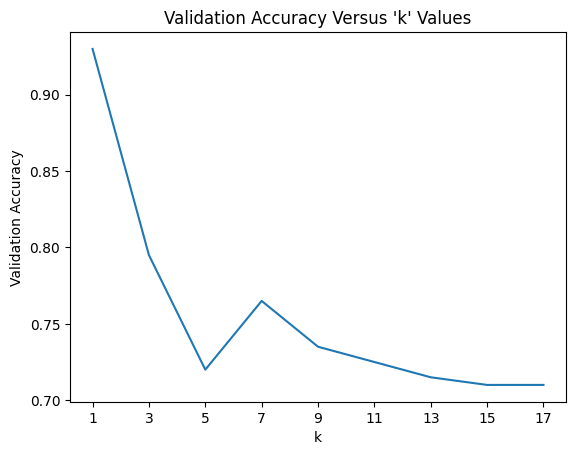

In [ ]:
import matplotlib.pyplot as plt
plt.plot(k_values, val_accs)
plt.xticks(k_values)
plt.xlabel('k')
plt.title("Validation Accuracy Versus 'k' Values")
plt.ylabel('Validation Accuracy')
plt.show()

In [ ]:
# 1) initialize a k-NN classifier with n_neighbors parameter set to k
knn = KNeighborsClassifier(n_neighbors=best_k)

X_train_new = selector.fit_transform(X_train, y_train) #BONUS
X_val_new = selector.transform(X_val) #BONUS

# 2) train the classifier using training set
knn.fit(X_train_new, y_train)
# 3) get the predictions of the classifier on the validation set
y_predict_val = knn.predict(X_val_new)
# 4) compute the accuracy of the predictions on the validation set and append it to val_accs list
accuracy = accuracy_score(y_val, y_predict_val)
val_accs.append(accuracy)
print(f"Test accuracy for best k = {best_k}: {accuracy:.4f}")


Test accuracy for best k = 1: 0.9300


#Logistic Regression

In [ ]:
# Define categorical and numerical features
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
numerical_features = ['Age', 'Credit amount', 'Duration']

# Handle missing values and one-hot encoding
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2 #BONUS
selector = SelectKBest(chi2, k=5) #BONUS

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('selector', selector),
                      ('model', LogisticRegression(solver='liblinear'))
                     ])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid for tuning
param_grid = {
    'model__C': [0.1, 1.0, 10.0]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict the labels of the test set using the best model
y_pred = best_model.predict(X_test)

# Accuracy
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print()

# Confusion matrix
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print()

# Best hyperparameters
print(f'Best Hyperparameters: {best_params}')
print()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')

Accuracy: 0.76

Confusion Matrix: 
[[ 22  37]
 [ 11 130]]

Best Hyperparameters: {'model__C': 1.0}

True Positives: 130
True Negatives: 22
False Positives: 37
False Negatives: 11


The output Best Hyperparameters: {'model__C': 10.0} means that the best hyperparameter value found during the hyperparameter tuning process is C = 10.0 for the logistic regression model.

In logistic regression, the C parameter represents the inverse of the regularization strength. A smaller value of C indicates stronger regularization, while a larger value of C indicates weaker regularization. In this case, the best hyperparameter value C = 10.0 suggests that a weaker regularization is preferred for the logistic regression model.

During the hyperparameter tuning process, GridSearchCV systematically evaluates different combinations of hyperparameters from the provided grid (in this case, only C), and it selects the hyperparameter values that result in the best performance, typically based on a specified scoring metric (e.g., accuracy).

Therefore, the output indicates that, based on the evaluation of different C values, the model achieved the best performance with C = 10.0, suggesting that weaker regularization (or no regularization) is optimal for this particular dataset and problem.


In the context of logistic regression, the C parameter represents the inverse of the regularization strength. It controls the amount of regularization applied to the logistic regression model.

Regularization is a technique used to prevent overfitting in a model by adding a penalty term to the loss function. In logistic regression, there are two commonly used types of regularization: L1 regularization (Lasso) and L2 regularization (Ridge).

The C parameter in logistic regression is the inverse of the regularization strength. A smaller value of C indicates stronger regularization, meaning the model will be more likely to generalize well but may have a higher bias. Conversely, a larger value of C indicates weaker regularization, allowing the model to fit the training data more closely, but potentially leading to overfitting.

When you perform hyperparameter tuning, you try different values for C to find the best trade-off between bias and variance. It's common to use a grid search or other techniques to search through a range of C values and select the one that yields the best performance on a validation set or through cross-validation.

Ultimately, the best value of C depends on the specific dataset and problem at hand. It's important to experiment with different values and evaluate the model's performance to find the optimal C for your logistic regression model.

#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

# Initialize feature selector
selector = SelectKBest(chi2, k=7)

# Define the hyperparameters to search over
# and their possible values
param_grid = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# Perform feature selection
X_train_new = selector.fit_transform(X_train, y_train) #BONUS
X_test_new = selector.transform(X_test) #BONUS

# Perform a grid search with 5-fold cross-validation
dt_clf = DecisionTreeClassifier()
grid_search = GridSearchCV(dt_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_new, y_train)

# Print the best hyperparameters found by the grid search
print(f"Best hyperparameters: {grid_search.best_params_}")

# Train the final model using all folds
dt_clf = DecisionTreeClassifier(**grid_search.best_params_)
dt_clf.fit(X_train_new, y_train)

# Evaluate the final model on the test data
test_acc = dt_clf.score(X_test_new, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Best hyperparameters: {'max_depth': 10, 'min_samples_split': 10}
Test accuracy: 0.7500


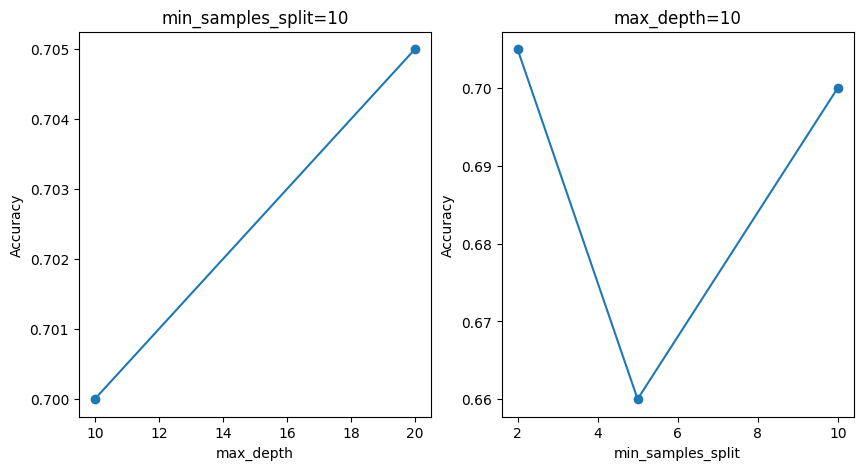

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

# Define the hyperparameters to search over
param_grid = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# Perform a grid search with 5-fold cross-validation
dt_clf = DecisionTreeClassifier()
grid_search = GridSearchCV(dt_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding test accuracy
best_params = grid_search.best_params_
best_score = grid_search.best_score_
test_acc = grid_search.score(X_test, y_test)

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy as a function of max_depth
max_depths = [None, 10, 20]
accuracies1 = []
for max_depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=best_params['min_samples_split'])
    dt_clf.fit(X_train, y_train)
    acc = dt_clf.score(X_test, y_test)
    accuracies1.append(acc)
ax1.plot(max_depths, accuracies1, marker='o')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Accuracy')
ax1.set_title(f"min_samples_split={best_params['min_samples_split']}")

# Plot the accuracy as a function of min_samples_split
min_samples_splits = [2, 5, 10]
accuracies2 = []
for min_samples_split in min_samples_splits:
    dt_clf = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=min_samples_split)
    dt_clf.fit(X_train, y_train)
    acc = dt_clf.score(X_test, y_test)
    accuracies2.append(acc)
ax2.plot(min_samples_splits, accuracies2, marker='o')
ax2.set_xlabel('min_samples_split')
ax2.set_ylabel('Accuracy')
ax2.set_title(f"max_depth={best_params['max_depth']}")

# Show the plot
plt.show()


As max_depth increases, accuracy increases but we cant increase it infinitely. Otherwise this leads to a overfitting on the training data and model memorizes the data. Then accuracy starts to decrease due to overfitting.

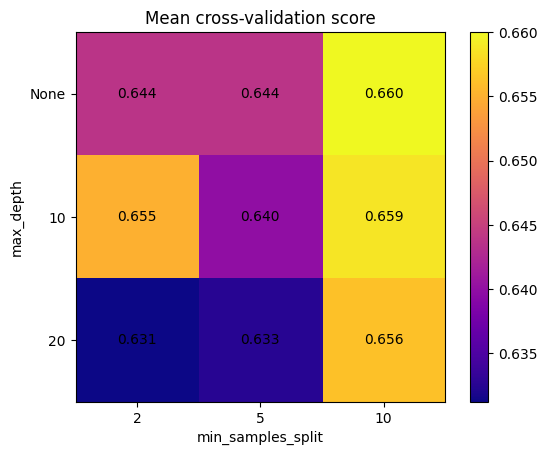

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

# Define the hyperparameters to search over
param_grid = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# Perform a grid search with 5-fold cross-validation
dt_clf = DecisionTreeClassifier()
grid_search = GridSearchCV(dt_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Plot the mean cross-validation score for each hyperparameter combination
scores = np.array(grid_search.cv_results_['mean_test_score']).reshape(3, 3)
max_depths = [str(d) for d in [None, 10, 20]]
min_samples_splits = [str(s) for s in [2, 5, 10]]
fig, ax = plt.subplots()
im = ax.imshow(scores, cmap='plasma')
ax.set_xticks(np.arange(len(min_samples_splits)))
ax.set_yticks(np.arange(len(max_depths)))
ax.set_xticklabels(min_samples_splits)
ax.set_yticklabels(max_depths)
ax.set_xlabel('min_samples_split')
ax.set_ylabel('max_depth')
ax.set_title('Mean cross-validation score')
for i in range(len(max_depths)):
    for j in range(len(min_samples_splits)):
        ax.text(j, i, f"{scores[i, j]:.3f}", ha="center", va="center")
plt.colorbar(im)
plt.show()